**Imports**

In [3138]:
import os
import numpy as np
import pandas as pd

from scipy.signal import butter, filtfilt, find_peaks, peak_widths, peak_prominences
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


**Daten laden**<br>
Rohdaten werden aus einem Verzeichnis geladen und einem Dictionary data hinzugefügt.<br>
Sollten Keine csv-Daten vorhanden sein bleibt das Dictionary data leer.

In [3139]:
# Laden aller Daten aus dem Ordner: 'csv_data'
def load_csv_data(folder_name):
    data = {}
    csv_folder = os.path.join(os.getcwd(), folder_name)

    if not os.path.exists(csv_folder):
        print(f"Error: The folder '{csv_folder}' was not found.")
        return data
    
    for file in os.listdir(csv_folder):
        if file.endswith('.csv'):
            file_path = os.path.join(csv_folder, file)
            try:
                filename = file.replace('.csv', '')
                data[filename] = pd.read_csv(file_path, delimiter=',')
            except Exception as e:
                print(f"Error reading {file}: {e}")

    return data


Die Funktion load_csv_data wird mit dem Parameter des Verzeichnises in dem sich die csv-Daten befinden aufgerufen und der Variable data zugewiesen.<br>
Danach wird versucht die jeweiligen Zeilen Gyroscope und Linear_Acceleration aus den jeweiligen Sprungdaten und Kniebeugendaten zu lesen.<br>
Sollte einer der Schlüssel nicht gefunden werden wird ein KeyError geworfen.

In [3140]:
data = load_csv_data('csv_training')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")


dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear Acceleration_Jump', 'Linear Acceleration_Squat'])
Key not found: 'Linear_Acceleration_Jump'


Es werden statische Informationen der jeweiligen Daten ausgegeben.

In [3141]:
print("Jump Accelerometer Data:")
print(jump_acc.describe())


Jump Accelerometer Data:
         Time (s)  Linear Acceleration x (m/s^2)  \
count  491.000000                     491.000000   
mean     2.578115                      -0.042210   
std      1.421324                       1.456871   
min      0.123730                      -6.199176   
25%      1.351029                      -0.755640   
50%      2.578109                       0.254770   
75%      3.805160                       0.803496   
max      5.032459                       3.475247   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                     491.000000                     491.000000  
mean                        0.438857                       1.336965  
std                         8.175259                       6.278102  
min                       -11.868484                     -10.892213  
25%                        -7.214042                      -3.235173  
50%                        -1.032273                       0.479285  
75%             

In [3142]:
print("Jump Gyroscope Data:")
print(jump_gyr.describe())


Jump Gyroscope Data:
         Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  491.000000           491.000000           491.000000   
mean     2.578115            -0.059810            -0.016064   
std      1.421324             1.172335             0.548693   
min      0.123730            -3.845624            -2.101971   
25%      1.351029            -0.706383            -0.345402   
50%      2.578109             0.019041             0.052995   
75%      3.805160             0.797327             0.352858   
max      5.032459             2.258294             1.365496   

       Gyroscope z (rad/s)  
count           491.000000  
mean             -0.001935  
std               0.332807  
min              -0.850988  
25%              -0.260716  
50%               0.011984  
75%               0.220770  
max               0.875888  


In [3143]:
print("Squat Accelerometer Data:")
print(squat_acc.describe())

Squat Accelerometer Data:
         Time (s)  Linear Acceleration x (m/s^2)  \
count  491.000000                     491.000000   
mean     2.579443                      -0.041278   
std      1.421293                       1.003600   
min      0.125132                      -5.402424   
25%      1.352373                      -0.334307   
50%      2.579386                       0.063273   
75%      3.806613                       0.434070   
max      5.033678                       2.587773   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                     491.000000                     491.000000  
mean                        0.180760                       0.575812  
std                         6.195645                       4.427812  
min                        -6.215872                      -6.347928  
25%                        -4.244205                      -2.106115  
50%                        -2.343599                      -0.763022  
75%            

In [3144]:
print("Squat Gyroscope Data:")
print(squat_gyr.describe())

Squat Gyroscope Data:
         Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  491.000000           491.000000           491.000000   
mean     2.579443            -0.000673            -0.007101   
std      1.421293             0.508921             0.404494   
min      0.125132            -2.070946            -1.261502   
25%      1.352373            -0.288811            -0.245803   
50%      2.579386             0.025432            -0.048202   
75%      3.806613             0.259784             0.202128   
max      5.033678             1.372020             1.554042   

       Gyroscope z (rad/s)  
count           491.000000  
mean              0.006874  
std               0.209768  
min              -0.778552  
25%              -0.128627  
50%               0.015180  
75%               0.122235  
max               0.676689  


Die Funktion trim_dataframes_to_shortest kürzt alle übergebenen Dataframes auf die Länge des kürzesten Dataframes.<br>
Es wird die minimale Länge aller Dataframes bestimmt und anschließend werden alle Dataframes auf die minimale Länge gekürzt.

In [3145]:
def trim_dataframes_to_shortest(df_list):
    # Bestimmen der minimalen Länge aller DataFrames in der Liste
    min_length = min(df.shape[0] for df in df_list)

    # Kürzen aller DataFrames auf die minimale Länge
    trimmed_dfs = [df.iloc[:min_length] for df in df_list]

    return trimmed_dfs

Hier wird die Funktion trim_dataframes_to_shortest mit den geladenen Daten aufgerufen.

In [3146]:
jump_acc, jump_gyr, squat_acc, squat_gyr = trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

Hier werden statische Informationen zu den nun gekürzten Daten ausgegeben.

In [3147]:
jump_acc.describe()

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2)
count,491.000000,491.000000,491.000000,491.000000
mean,2.578115,-0.042210,0.438857,1.336965
std,1.421324,1.456871,8.175259,6.278102
min,0.123730,-6.199176,-11.868484,-10.892213
25%,1.351029,-0.755640,-7.214042,-3.235173
50%,2.578109,0.254770,-1.032273,0.479285
75%,3.805160,0.803496,8.459617,5.693766
max,5.032459,3.475247,16.086550,25.037260


In [3148]:
jump_gyr.describe()

,Time (s),Gyroscope x (rad/s),Gyroscope y (rad/s),Gyroscope z (rad/s)
count,491.000000,491.000000,491.000000,491.000000
mean,2.578115,-0.059810,-0.016064,-0.001935
std,1.421324,1.172335,0.548693,0.332807
min,0.123730,-3.845624,-2.101971,-0.850988
25%,1.351029,-0.706383,-0.345402,-0.260716
50%,2.578109,0.019041,0.052995,0.011984
75%,3.805160,0.797327,0.352858,0.220770
max,5.032459,2.258294,1.365496,0.875888


**Funktion zum Plotten**<br>
Die Funktion compare_acc_gyr erhält Daten aus den Accelerometer- und Gyroscope-DataFrames und plottet diese.<br>
Als erstes wird ein neuer subplot erstellt.<br>
Danach wird für jede Achse ein Scatter-Plot angelegt.<br>
Abschließend wird das Layout des Plots aktualisiert und ausgegeben.

In [3149]:
def compare_acc_gyr(acc_df,gyr_df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration x (m/s^2)'], name='Accel X'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=acc_df['Time (s)'], y=acc_df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope y (rad/s)'], marker=dict(size=4), name='Gyr Y'), row=2, col=1)
    fig.add_trace(go.Scatter(x=gyr_df['Time (s)'], y=gyr_df['Gyroscope z (rad/s)'], marker=dict(size=4), name='Gyr Z'), row=2, col=1)

    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

Es wird die Funktion compare_acc_gyr mit den Sprung- bzw Kniebeugen-Daten aufgerufen.

In [3150]:
compare_acc_gyr(jump_acc,jump_gyr)

In [3151]:
compare_acc_gyr(squat_acc,squat_gyr)

### Relevante Spalten extrahieren

In [3152]:
print(jump_acc.describe())

         Time (s)  Linear Acceleration x (m/s^2)  \
count  491.000000                     491.000000   
mean     2.578115                      -0.042210   
std      1.421324                       1.456871   
min      0.123730                      -6.199176   
25%      1.351029                      -0.755640   
50%      2.578109                       0.254770   
75%      3.805160                       0.803496   
max      5.032459                       3.475247   

       Linear Acceleration y (m/s^2)  Linear Acceleration z (m/s^2)  
count                     491.000000                     491.000000  
mean                        0.438857                       1.336965  
std                         8.175259                       6.278102  
min                       -11.868484                     -10.892213  
25%                        -7.214042                      -3.235173  
50%                        -1.032273                       0.479285  
75%                         8.459617     

In [3153]:
print(jump_gyr.describe())

         Time (s)  Gyroscope x (rad/s)  Gyroscope y (rad/s)  \
count  491.000000           491.000000           491.000000   
mean     2.578115            -0.059810            -0.016064   
std      1.421324             1.172335             0.548693   
min      0.123730            -3.845624            -2.101971   
25%      1.351029            -0.706383            -0.345402   
50%      2.578109             0.019041             0.052995   
75%      3.805160             0.797327             0.352858   
max      5.032459             2.258294             1.365496   

       Gyroscope z (rad/s)  
count           491.000000  
mean             -0.001935  
std               0.332807  
min              -0.850988  
25%              -0.260716  
50%               0.011984  
75%               0.220770  
max               0.875888  


Die Funktion combine_relevant_columns erhält zwei Dataframes und erstellt ein neues Dataframe das nur bestimmte relevante Daten enthält.<br>
Es werden die Spalten für die Lineare Beschleunigung auf der z und y Achse sowie die x Achse und die Zeit des Gyroscopes gelesen.<br>
Am Ende wird ein neues Dataframe ausgegeben mit den gelesenen Spalten.<br>

In [3154]:
def combine_relevant_columns(acc_df, gyr_df):
    linear_acc_z = acc_df['Linear Acceleration z (m/s^2)']
    linear_acc_y = acc_df['Linear Acceleration y (m/s^2)']

    gyroskop_x = gyr_df['Gyroscope x (rad/s)']

    time = gyr_df['Time (s)']

    return pd.DataFrame({
        'Time (s)': time,
        'Linear Acceleration z (m/s^2)': linear_acc_z,
        'Linear Acceleration y (m/s^2)': linear_acc_y,
        'Gyroscope x (rad/s)': gyroskop_x
    })

Hier wird die Funktion combine_relevant_columns aufgerufen und anschließend werden statische Informationen sowie die ersten Zeilen des Dataframes ausgegeben.

In [3155]:
combined_df = combine_relevant_columns(jump_acc, jump_gyr)
print(combined_df.describe())

         Time (s)  Linear Acceleration z (m/s^2)  \
count  491.000000                     491.000000   
mean     2.578115                       1.336965   
std      1.421324                       6.278102   
min      0.123730                     -10.892213   
25%      1.351029                      -3.235173   
50%      2.578109                       0.479285   
75%      3.805160                       5.693766   
max      5.032459                      25.037260   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                     491.000000           491.000000  
mean                        0.438857            -0.059810  
std                         8.175259             1.172335  
min                       -11.868484            -3.845624  
25%                        -7.214042            -0.706383  
50%                        -1.032273             0.019041  
75%                         8.459617             0.797327  
max                        16.086550             2.

In [3156]:
print(combined_df.describe())


         Time (s)  Linear Acceleration z (m/s^2)  \
count  491.000000                     491.000000   
mean     2.578115                       1.336965   
std      1.421324                       6.278102   
min      0.123730                     -10.892213   
25%      1.351029                      -3.235173   
50%      2.578109                       0.479285   
75%      3.805160                       5.693766   
max      5.032459                      25.037260   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                     491.000000           491.000000  
mean                        0.438857            -0.059810  
std                         8.175259             1.172335  
min                       -11.868484            -3.845624  
25%                        -7.214042            -0.706383  
50%                        -1.032273             0.019041  
75%                         8.459617             0.797327  
max                        16.086550             2.

In [3157]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)

In [3158]:
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

**Fast Fourier Transformation**<br>
Die Funktion plot_frequencies nutzt die Fast Fourier Transformation um die Frequenzen von Daten aus dem Dataframe zu analysieren und darzustellen.<br>
Es wird ein neuer Plot erstellt.<br>
Die Spalte Time (s) wird aus dem Dataframe entfernt da sie für die Frequenzanalyse nicht benötigt wird.<br>
Danach wird die Anzahl der verbleibenden Spalten im gefilterten Dataframe ermittelt.<br>
Als nächstes wird eine Schleife durchlaufen um die Frequenzanalyse für jede Spalte im Dataframe durchzuführen.<br>
Die Amplituden werden normalisiert in dem sie durch den Maximalen Amplitudenwert geteilt werden.<br>
Es werden nur die positiven Frequenzen betrachtet und die entsprechenden Werte werden extrahiert.<br>
Als letztes werden die einzelnen Subplots erstellt wobei für jede Spalte im Dataframe ein eigener Subplot erstellt wird.<br>
Es wird in jedem Subplot die Frequenz gegen die normalisierte Amplitude aufgetragen.<br>
Abschließend wird mit tight_layout gewährleistet das die Subplots ordentlich angeordnet sind um Überlappungen zu vermeiden und die Plots werden ausgegeben.<br>

In [3159]:
def plot_frequencies(dataframe):
    plt.figure(figsize=(15, 5))

    filtered_df = dataframe.drop(columns=['Time (s)'])
    num_columns = len(filtered_df.columns)

    for i, column in enumerate(filtered_df.columns, 1):
        dataframe_col = filtered_df[column]
        dft = np.fft.fft(dataframe_col)
        frequencies = np.fft.fftfreq(len(dataframe_col))
        amplitudes = np.abs(dft)

        # Normalisierung der Amplituden
        max_amplitude = np.max(amplitudes)
        normalized_amplitudes = amplitudes / max_amplitude

        # Filtern für positive Frequenzen
        positive_indices = np.where(frequencies > 0)
        positive_frequencies = frequencies[positive_indices]
        positive_normalized_amplitudes = normalized_amplitudes[positive_indices]

        # Erstellen der Subplots
        plt.subplot(1, num_columns, i)
        plt.plot(positive_frequencies, positive_normalized_amplitudes)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Normalized Amplitude')
        plt.title(f"Frequency {column}")

    plt.tight_layout()
    plt.show()

Aufruf der Funktion plot_frequencies mit den Kniebeugen-Daten

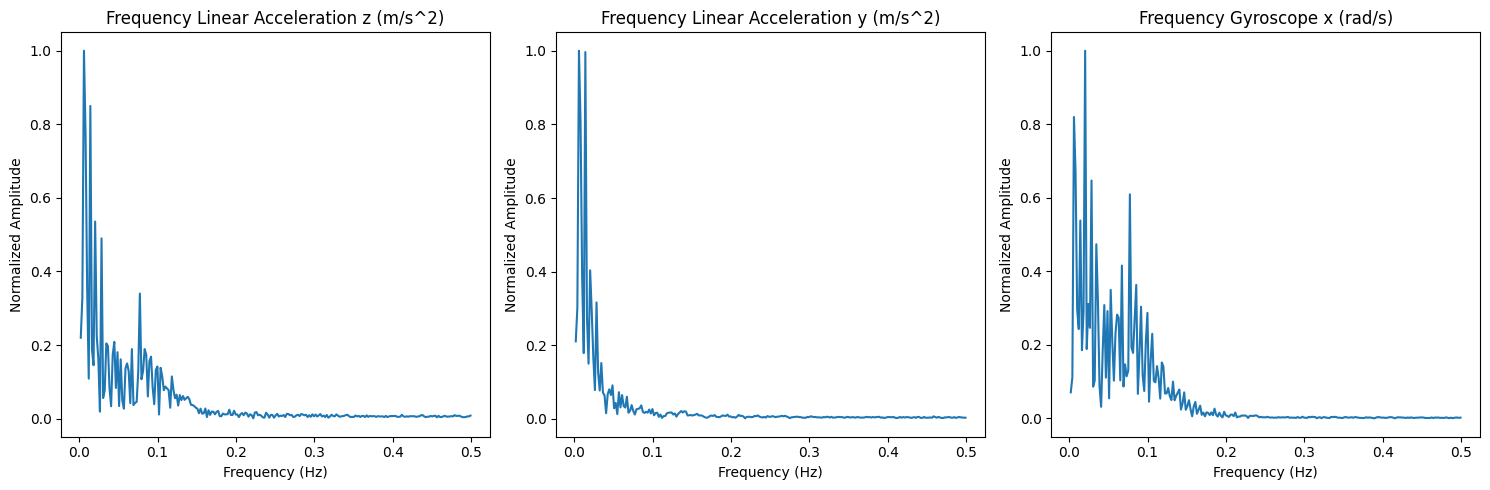

In [3160]:
plot_frequencies(squat_df)

Aufruf der Funktion plot_frequencies mit den Springen-Daten

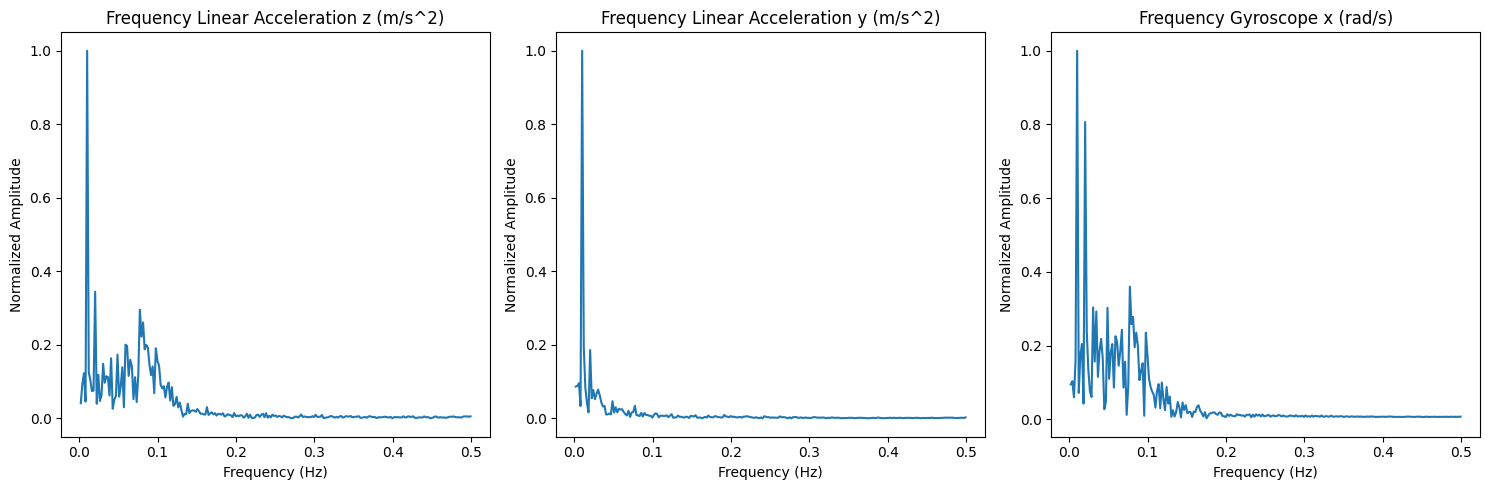

In [3161]:
plot_frequencies(jump_df)

### Filtern der Frequenzen

Die Funktion filter_frequency führt einen Butterworth-Tiefpassfilter auf das mitgegebene Dataframe durch.<br>
Es wird eine Kopie des übergebenen Dataframes erstellt um die gefilterten Daten zu speichern.<br>
Die Filterordnung wird auf 5 festgelegt und der low_cutoff Frequenz wird auf 5Hz festgelegt.<br>
Als nächstes wird der Butterworth Tiefpassfilter erstellt mit b und a als Koeffizienten.<br>
Es wird über alle Spalten außer Time (s) mit einer Schleife iteriert und der Filter wird auf die jeweiligen Spalten angewendet und in das neue Kopierte Dataframe gespeichert.<br>
Abschließend wird das Dataframe mit den neuen gefilterten Daten zurückgegeben.

In [3162]:
def filter_frequency(dataframe):
    # Kopie des DataFrames erstellen
    filtered_dataframe = dataframe.copy()

    # Festlegen der Cutoff-Frequenz und der Filterordnung
    filter_order = 5
    low_cutoff = 10

    # Butterworth Tiefpass erstellen
    b, a = butter(filter_order, low_cutoff, btype='low', analog=False, fs=100)

    # Schleife über alle Spalten außer 'Time (s)'
    for column in dataframe.columns:
        if column != 'Time (s)':
            # Hochpassfilter auf die Signalreihe anwenden
            filtered_signal = filtfilt(b, a, dataframe[column])
            filtered_dataframe[column] = filtered_signal

    return filtered_dataframe

Hier wird die Funktion filter_frequency mit den Kniebeuge-Daten aufgerufen.

In [3163]:
filtered_df_sq = filter_frequency(squat_df)

Hier wird die Funktion filter:frequency mit den Springen-Daten aufgerufen.

In [3164]:
filtered_df_j = filter_frequency(jump_df)

**Funktion zum Plotten der gefilterten Daten**<br>
Die Funktion plot_df nimmt ein Dataframe und gibt am Ende ein Plot aus.<br>
Es werden zwei Subplots erstellt um jeweils die Lineare Beschleunigung auf der x und y -Achse des Dataframes zu visiualisieren.<br>
Es wird ein weiterer Subplot erstellt um die Daten des Gyroscopes auf der x-Achse zu visiualisieren.

In [3165]:
def plot_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

Die Funktion plot_normal_df gibt Plots für Normalisierte-Daten aus einem Dataframe aus.<br>
Es werden zwei Subplots erstellt um jeweils die Lineare Beschleunigung auf der y und z -Achse des Dataframes zu visiualisieren.<br>
Es wird ein weiterer Subplot für die normalisierten-Gyroscopedaten an der x-Achse erstellt.<br>
Die erstellten Plots werden am Ende ausgegeben.

In [3166]:
def plot_normal_df(df):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accelerometer', 'Gyroscope'), vertical_spacing=0.1, row_heights=[3, 3, 3])
    # Subplot 1: Accelerometer-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Y'], name='Accel Y'))
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Z'], name='Accel Z'))

    # Subplot 2: Gyroscope-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Z_Score_Gyr_X'], marker=dict(size=4), name='Gyr X'), row=2, col=1)


    # Aktualisiere Layout und Labels
    fig.update_layout(
                    xaxis_title='Zeit (s)',
                    yaxis_title='Wert',
                    legend_title='Achse',
                    height=800, width=1000)
    fig.show()

**Frequenz gefiltert**<br>
Beobachtungen für Springen sowie Kniebeugen Plots:<br>
Die Plots der beiden Beschleunigungen auf der y sowie z -Achse sind sich extrem ähnlich.<br>
Die Ausschläge des Gyroscopes passen zu den Ausschlägen der Beschleunigung.

In [3167]:
plot_df(filtered_df_j)

In [3168]:
plot_df(filtered_df_sq)

In [3169]:
def normalize_df(df, columns_to_scale):
    # Kopie des DataFrames erstellen
    normalized_df = df.copy()

    # Initialisieren des MinMaxScaler
    scaler = MinMaxScaler()

    # Fit des Scalers auf die Daten
    scaler.fit(normalized_df[columns_to_scale])

    # Transformieren der Daten
    normalized_columns = scaler.transform(normalized_df[columns_to_scale])
    
    # Ersetzen der Originaldaten durch die normalisierten Daten
    normalized_df[columns_to_scale] = normalized_columns

    return normalized_df

In [3170]:
columns_to_normalize = ['Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Gyroscope x (rad/s)']

# Anwenden der Normalisierungsfunktion
normalized_df_sq = normalize_df(filtered_df_sq, columns_to_normalize)
normalized_df_j = normalize_df(filtered_df_j, columns_to_normalize)

# Nun sollten die normalisierten DataFrames auch die 'Time (s)' Spalte enthalten
print(normalized_df_sq.head())
print(normalized_df_j.head())

   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.125132                       0.250297                       0.219663   
1  0.135180                       0.243450                       0.214689   
2  0.145231                       0.237100                       0.209332   
3  0.155285                       0.231663                       0.203238   
4  0.165339                       0.227423                       0.196215   

   Gyroscope x (rad/s)  
0             0.559032  
1             0.567667  
2             0.575012  
3             0.580353  
4             0.583605  
   Time (s)  Linear Acceleration z (m/s^2)  Linear Acceleration y (m/s^2)  \
0  0.123730                       0.360189                       0.342745   
1  0.133779                       0.431067                       0.337596   
2  0.143831                       0.485060                       0.329347   
3  0.153887                       0.508823                       0.315887   
4 

Außreißer gefiltert

In [3171]:
plot_df(normalized_df_sq)

In [3172]:
plot_df(normalized_df_j)

In [3173]:
sq_peaks, _ = find_peaks(normalized_df_sq['Linear Acceleration y (m/s^2)'],prominence=0.5, height=0.5)
peak_distances = np.diff(sq_peaks)
sq_max_distance = np.max(peak_distances)

j_peaks, _ = find_peaks(normalized_df_j['Linear Acceleration y (m/s^2)'],prominence=0.5,height=0.5)
peak_distances = np.diff(j_peaks)
j_max_distance = np.max(peak_distances)


print(f"Anzahl der Peaks: {len(sq_peaks)}")
print(f"Anzahl der Peaks: {len(j_peaks)}")

Anzahl der Peaks: 3
Anzahl der Peaks: 5


In [3174]:
normalized_df_sq['Label'] = 'squat'
normalized_df_j['Label'] = 'jump'

In [3175]:
def create_windows_and_labels(df, peaks, window_size):
    # Leere Listen für Fenster und Labels erstellen
    windows = []
    label_list = []

    # Schleife über alle Peaks
    for peak in peaks:
        half_window = window_size // 2

        # Start- und Endindex des Fensters berechnen
        start_index = max(peak - half_window, 0)  # Sicherstellen, dass der Index nicht negativ wird
        end_index = min(peak + half_window, df.shape[0])  # Sicherstellen, dass der Index nicht über das DataFrame hinausgeht

        # Fenster erstellen
        window = df.iloc[start_index:end_index]
        windows.append(window)

        # Label für den Peak extrahieren
        label = df.iloc[peak]['Label']
        label_list.append(label)

    # Erstellen eines DataFrame für Labels
    label_df = pd.DataFrame(label_list, columns=['Label'])

    return windows, label_df


In [3176]:
def create_windows(df, peaks, window_size):
    # Leere Listen für Fenster und Labels erstellen
    windows = []

    # Schleife über alle Peaks
    for peak in peaks:
        half_window = window_size // 2

        # Start- und Endindex des Fensters berechnen
        start_index = max(peak - half_window, 0)  # Sicherstellen, dass der Index nicht negativ wird
        end_index = min(peak + half_window, df.shape[0])  # Sicherstellen, dass der Index nicht über das DataFrame hinausgeht

        # Fenster erstellen
        window = df.iloc[start_index:end_index]
        windows.append(window)

    return windows


In [3177]:
sq_windows, sq_label_df = create_windows_and_labels(normalized_df_sq,sq_peaks, sq_max_distance)

In [3178]:
j_windows,j_label_df = create_windows_and_labels(normalized_df_j,j_peaks, j_max_distance)

In [3179]:
def plot_windows_with_data(df, windows, peaks):
    # Farben für die Fenster in Accel Y definieren
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']

    # Erstellen des Plots mit Plotly
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('Accel Y', 'Gyro X', 'Accel Z'))

    # Hinzufügen der Accelerometer Y-Daten und Peaks
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration y (m/s^2)'], name='Accel Y', line=dict(color='grey')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Time (s)'].iloc[peaks], y=df['Linear Acceleration y (m/s^2)'].iloc[peaks], mode='markers', marker=dict(color='red', size=6), name='Peaks Y'), row=1, col=1)

    # Hervorheben der Fenster in Accel Y mit verschiedenen Farben
    for i, window in enumerate(windows):
        window_color = colors[i % len(colors)]
        fig.add_trace(go.Scatter(x=window['Time (s)'], y=window['Linear Acceleration y (m/s^2)'], mode='lines', line=dict(color=window_color, width=2)), row=1, col=1)

    # Hinzufügen der Gyroscope X-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Gyroscope x (rad/s)'], name='Gyro X', line=dict(color='blue')), row=2, col=1)

    # Hinzufügen der Linear Acceleration Z-Daten
    fig.add_trace(go.Scatter(x=df['Time (s)'], y=df['Linear Acceleration z (m/s^2)'], name='Accel Z', line=dict(color='green')), row=3, col=1)

    # Update layout and labels
    fig.update_layout(title='Accelerometer Daten mit Peaks und farblichen Fenstern in Accel Y', xaxis_title='Zeit (s)', height=900)
    fig.show()


In [3180]:
plot_windows_with_data(normalized_df_sq, sq_windows, sq_peaks)

In [3181]:
print(normalized_df_sq.describe())

         Time (s)  Linear Acceleration z (m/s^2)  \
count  491.000000                     491.000000   
mean     2.579443                       0.279571   
std      1.421293                       0.180330   
min      0.125132                       0.000000   
25%      1.352373                       0.165090   
50%      2.579386                       0.224493   
75%      3.806613                       0.328679   
max      5.033678                       1.000000   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                     491.000000           491.000000  
mean                        0.242506             0.523933  
std                         0.236630             0.170652  
min                         0.000000             0.000000  
25%                         0.073641             0.419942  
50%                         0.144480             0.529006  
75%                         0.334871             0.612309  
max                         1.000000             1.

In [3182]:
plot_windows_with_data(normalized_df_j, j_windows, j_peaks)

In [3183]:
print(normalized_df_j.describe())

         Time (s)  Linear Acceleration z (m/s^2)  \
count  491.000000                     491.000000   
mean     2.578115                       0.403421   
std      1.421324                       0.195807   
min      0.123730                       0.000000   
25%      1.351029                       0.262698   
50%      2.578109                       0.372149   
75%      3.805160                       0.532139   
max      5.032459                       1.000000   

       Linear Acceleration y (m/s^2)  Gyroscope x (rad/s)  
count                     491.000000           491.000000  
mean                        0.437149             0.584618  
std                         0.296286             0.209528  
min                         0.000000             0.000000  
25%                         0.160112             0.454110  
50%                         0.376476             0.598885  
75%                         0.727825             0.743228  
max                         1.000000             1.

In [3184]:
def balance_windows_and_labels(smaller_windows, larger_windows, smaller_label_df, larger_label_df):
    factor = int(len(larger_windows) / len(smaller_windows))
    smaller_windows_balanced = smaller_windows * factor
    smaller_label_df_balanced = pd.concat([smaller_label_df] * factor, ignore_index=True)

    # Überprüfen, ob zusätzliche Fenster benötigt werden
    if factor == 1:
        difference = len(larger_windows) - len(smaller_windows_balanced)
        additional_windows = smaller_windows[:difference]
        additional_labels = smaller_label_df.iloc[:difference]

        smaller_windows_balanced += additional_windows
        smaller_label_df_balanced = pd.concat([smaller_label_df_balanced, additional_labels], ignore_index=True)

    return smaller_windows_balanced, smaller_label_df_balanced


In [3185]:
def balance_windows(smaller_windows, larger_windows):
    factor = int(len(larger_windows) / len(smaller_windows))
    smaller_windows_balanced = smaller_windows * factor
    # Überprüfen, ob zusätzliche Fenster benötigt werden
    if factor == 1:
        difference = len(larger_windows) - len(smaller_windows_balanced)
        additional_windows = smaller_windows[:difference]

        smaller_windows_balanced += additional_windows

    return smaller_windows_balanced


In [3186]:
print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")

if len(sq_windows) < len(j_windows):
    # Balance Jump Windows to match Squat Windows
    sq_windows, sq_label_df = balance_windows_and_labels(sq_windows, j_windows, sq_label_df, j_label_df)
else:
    # Balance Squat Windows to match Jump Windows
    j_windows, j_label_df = balance_windows_and_labels(j_windows, sq_windows, j_label_df, sq_label_df)

print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")

label_df = pd.concat([sq_label_df, j_label_df], ignore_index=True)
windows = sq_windows + j_windows


Anzahl der Fenster für jump: 5
Anzahl der Fenster für squat: 3
Anzahl der Fenster für jump: 5
Anzahl der Fenster für squat: 5


In [3187]:
print(label_df.tail())

  Label
5  jump
6  jump
7  jump
8  jump
9  jump


In [3188]:
def create_feature_df(windows):
    # Leere Liste erstellen, um Features zu speichern
    feature_list = []

    sampling_rate = 100

    # Jeden DataFrame in windows einzeln durchgehen und für jede der drei Achsen die Features berechnen
    for window in windows:
        acc_y = window['Linear Acceleration y (m/s^2)']
        acc_z = window['Linear Acceleration z (m/s^2)']
        gyro_x = window['Gyroscope x (rad/s)']
        window_length = len(window)

        max_acc_y = acc_y.max()
        mean_acc_y = acc_y.mean()
        time_to_peak_acc_y = acc_y.idxmax() / sampling_rate
        slope_acc_y = (acc_y.iloc[-1] - acc_y.iloc[0]) / window_length

        max_acc_z = acc_z.max()
        mean_acc_z = acc_z.mean()
        time_to_peak_acc_z = acc_z.idxmax() / sampling_rate
        slope_acc_z = (acc_z.iloc[-1] - acc_z.iloc[0]) / window_length

        mean_gyro_x = gyro_x.mean()

        # Berechnete Werte an Liste anhängen, unter entsprechend benannten Spalten
        features = {
            'window_length': window_length,
            'acc_y_std_dev': acc_y.std(),
            'acc_y_variance': acc_y.var(),
            'acc_y_signal_energy': np.sum(acc_y**2) / window_length,
            # 'max_acc_y': max_acc_y,
            # 'mean_acc_y': mean_acc_y,
            # 'time_to_peak_acc_y': time_to_peak_acc_y,
            # 'slope_acc_y': slope_acc_y,
            # 'acc_z_std_dev': acc_z.std(),
            # 'acc_z_variance': acc_z.var(),
            'acc_z_signal_energy': np.sum(acc_z**2) / window_length,
            # 'max_acc_z': max_acc_z,
            # 'mean_acc_z': mean_acc_z,
            # 'time_to_peak_acc_z': time_to_peak_acc_z,
            # 'slope_acc_z': slope_acc_z,
            # 'gyro_x_std_dev': gyro_x.std(),
            # 'gyro_x_variance': gyro_x.var(),
            'gyro_x_signal_energy': np.sum(gyro_x**2)/ window_length,
            # 'mean_gyro_x': mean_gyro_x,
            # 'max_gyro_x': gyro_x.max()
        }
        feature_list.append(features)

    return pd.DataFrame(feature_list)


Genauigkeit des Entscheidungsbaum-Classifiers: 1.0


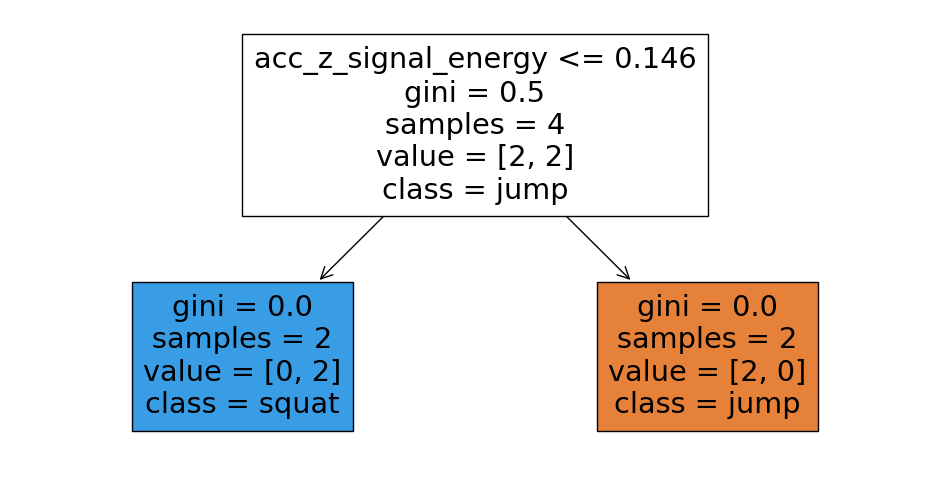

|--- acc_z_signal_energy <= 0.15
|   |--- class: squat
|--- acc_z_signal_energy >  0.15
|   |--- class: jump



In [3189]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Angenommen, feature_df und label_df sind bereits definiert
feature_df = create_feature_df(windows)
X = feature_df
y = label_df

# Daten aufteilen mit stratifizierter Aufteilung
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42, stratify=y)

# Erstelle und trainiere den Entscheidungsbaum-Classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Mache Vorhersagen auf dem Testset
y_pred = clf.predict(X_test)

# Berechne die Genauigkeit des Classifiers
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit des Entscheidungsbaum-Classifiers: {accuracy}")

# Visualisiere den Entscheidungsbaum
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X.columns.tolist(), class_names=clf.classes_.tolist())
plt.show()

# Visualisiere den Entscheidungsbaum in Textform
tree_text = export_text(clf, feature_names=X.columns.tolist())
print(tree_text)


Clustering

In [3190]:
from sklearn.cluster import KMeans

# Anzahl der gewünschten Cluster festlegen 
anzahl_cluster = 2  # Passe dies an deine Anforderungen an.

# Initialisierung des K-Means-Cluster-Algorithmus
kmeans = KMeans(n_clusters=anzahl_cluster, random_state=0)

# Clustering auf den Daten in 'feature_df' durchführen
cluster_labels = kmeans.fit_predict(feature_df)

# Berechnete Cluster zu jedem der Datenpunkte im Feature Dataframe zuordnungen
feature_df['Cluster'] = cluster_labels

# Gib das aktualisierte DataFrame mit Clusterzuordnungen aus.
#print(feature_df.head())
feature_df.columns


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Index(['window_length', 'acc_y_std_dev', 'acc_y_variance',
       'acc_y_signal_energy', 'acc_z_signal_energy', 'gyro_x_signal_energy',
       'Cluster'],
      dtype='object')

Testdaten einlesen

In [3191]:
data = load_csv_data('csv_short')
print(data.keys())

try:
    jump_acc = data['Linear_Acceleration_Jump']
    jump_gyr = data['Gyroscope_Jump']
    squat_acc = data['Linear_Acceleration_Squat']
    squat_gyr = data['Gyroscope_Squat']
except KeyError as e:
    print(f"Key not found: {e}")

dict_keys(['Gyroscope_Jump', 'Gyroscope_Squat', 'Linear_Acceleration_Jump', 'Linear_Acceleration_Squat'])


In [3192]:
jump_acc, jump_gyr, squat_acc, squat_gyr = trim_dataframes_to_shortest([jump_acc, jump_gyr, squat_acc, squat_gyr])

In [3193]:
jump_df = combine_relevant_columns(jump_acc, jump_gyr)
squat_df = combine_relevant_columns(squat_acc, squat_gyr)

In [3194]:
filtered_df_j = filter_frequency(jump_df)
filtered_df_sq = filter_frequency(squat_df)

In [3195]:
columns_to_normalize = ['Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Gyroscope x (rad/s)']
normalized_df_j = normalize_df(filtered_df_j, columns_to_normalize)
normalized_df_sq = normalize_df(filtered_df_sq, columns_to_normalize)

In [3196]:
sq_peaks, _ = find_peaks(normalized_df_sq['Linear Acceleration y (m/s^2)'],prominence=0.5, height=0.5)
peak_distances = np.diff(sq_peaks)
sq_max_distance = np.max(peak_distances)

j_peaks, _ = find_peaks(normalized_df_j['Linear Acceleration y (m/s^2)'],prominence=0.5,height=0.5)
peak_distances = np.diff(j_peaks)
j_max_distance = np.max(peak_distances)


print(f"Anzahl der Peaks: {len(sq_peaks)}")
print(f"Anzahl der Peaks: {len(j_peaks)}")

Anzahl der Peaks: 3
Anzahl der Peaks: 5


In [3197]:
sq_windows = create_windows(normalized_df_sq, sq_peaks, sq_max_distance)
j_windows = create_windows(normalized_df_j, j_peaks, j_max_distance)

In [3198]:
if len(sq_windows) < len(j_windows):
    # Balance Jump Windows to match Squat Windows
    sq_windows = balance_windows(sq_windows, j_windows)
else:
    # Balance Squat Windows to match Jump Windows
    j_windows = balance_windows(j_windows, sq_windows)

print(f"Anzahl der Fenster für jump: {len(j_windows)}")
print(f"Anzahl der Fenster für squat: {len(sq_windows)}")

windows = sq_windows + j_windows

Anzahl der Fenster für jump: 5
Anzahl der Fenster für squat: 5


In [3199]:
feature_df = create_feature_df(windows)

In [3200]:
new_predictions = clf.predict(feature_df)

print(new_predictions)

['squat' 'squat' 'squat' 'squat' 'squat' 'jump' 'jump' 'jump' 'jump'
 'jump']
